In [1]:
import os
import sys
import shutil
import argparse
from collections import namedtuple

import numpy as np
import numpy.random as npr

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex, clear_output

In [2]:
import tqdm

if not torch.cuda.is_available(): 
    print('[WARNING] Not using GPU.')
    print('Please select "Runtime -> Change runtime type" and switch to GPU for better performance')
else:
    print('Using', torch.cuda.get_device_name(0))

Using GeForce GTX 1080 Ti


# Introduction to SATNet

SATNet is a differentiable (smoothed) maximum satisfiability (MAXSAT) solver that can be integrated into the loop of larger deep learning systems.  Our (approximate) solver is based upon a fast coordinate descent approach to solving the semidefinite program (SDP) associated with the MAXSAT problem.

The code below reproduces the Sudoku experiments from our paper "SATNet: Bridging deep learning and logical reasoning using a differentiable satisfiability solver." These experiments show that by integrating the SATNet solver into end-to-end learning systems, we can learn the logical structure of challenging problems in a minimally supervised fashion. In particular, this notebook shows how we can learn to:
* Play **9×9 Sudoku (original and permuted)** solely from examples.
* Solve a **"visual Sudoku"** problem that maps images of Sudoku puzzles to their associated logical solutions. 

For more details and discussion about these experiments, please see the [SATNet paper](https://icml.cc/Conferences/2019/Schedule?showEvent=3947).

In [3]:
import satnet
print('SATNet document\n', satnet.SATNet.__doc__)

SATNet document
 Apply a SATNet layer to complete the input probabilities.

    Args:
        n: Number of input variables.
        m: Rank of the clause matrix.
        aux: Number of auxiliary variables.

        max_iter: Maximum number of iterations for solving
            the inner optimization problem.
            Default: 40
        eps: The stopping threshold for the inner optimizaiton problem.
            The inner Mixing method will stop when the function decrease
            is less then eps times the initial function decrease.
            Default: 1e-4
        prox_lam: The diagonal increment in the backward linear system
            to make the backward pass more stable.
            Default: 1e-2
        weight_normalize: Set true to perform normlization for init weights.
            Default: True

    Inputs: (z, is_input)
        **z** of shape `(batch, n)`: 
            Float tensor containing the probabilities (must be in [0,1]).
        **is_input** of shape `(batch, 

In [4]:
torch.cuda.is_available()

True

# Building SATNet-based Models

To solve **Sudoku** and a **permuted version of Sudoku**: We construct a SATNet-based SudokuSolver layer that takes as input a logical (bit) representation of the initial Sudoku board along with a mask representing which bits must be learned (i.e. all bits in empty Sudoku cells). This input is vectorized. Given this input, the SudokuSolver layer then outputs a bit representation of the Sudoku board with guesses for the unknown bits.

In [5]:
class SudokuSolver(nn.Module):
    def __init__(self, boardSz, aux, m):
        super(SudokuSolver, self).__init__()
        n = boardSz**6
        self.sat = satnet.SATNet(n, m, aux)

    def forward(self, y_in, mask):
        out = self.sat(y_in, mask)
        del y_in, mask
        return out

To solve **"visual Sudoku"**: We construct a (standard) convolutional neural network for MNIST digit recognition and train it end-to-end with our SudokuSolver layer. This architecture takes in an image representation of a Sudoku board constructed with MNIST digits. Each MNIST digit is classified by the convolutional network, and the resulting (estimated) logical representation of the initial Sudoku board is then fed as input to the SudokuSolver layer. (As described earlier, the SudokuSolver layer then outputs a bit representation of the Sudoku board with guesses for the unknown bits.)

In [6]:
class DigitConv(nn.Module):
    '''
    Convolutional neural network for MNIST digit recognition. From:
    https://github.com/pytorch/examples/blob/master/mnist/main.py
    '''
    def __init__(self):
        super(DigitConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)[:,:9].contiguous()

class MNISTSudokuSolver(nn.Module):
    def __init__(self, boardSz, aux, m):
        super(MNISTSudokuSolver, self).__init__()
        self.digit_convnet = DigitConv()
        self.sudoku_solver = SudokuSolver(boardSz, aux, m)
        self.boardSz = boardSz
        self.nSq = boardSz**2
    
    def forward(self, x, is_inputs):
        nBatch = x.shape[0]
        x = x.flatten(start_dim = 0, end_dim = 1)
        digit_guess = self.digit_convnet(x)
        puzzles = digit_guess.view(nBatch, self.nSq * self.nSq * self.nSq)

        solution = self.sudoku_solver(puzzles, is_inputs)
        return solution

In [7]:
sys.path.insert(0, os.path.abspath('../'))

The experimental parameters we use in the paper are below.

In [8]:
from exps.sudoku import train, test, FigLogger, find_unperm
args_dict = {'lr': 2e-3, 
             'cuda': torch.cuda.is_available(), 
             'batchSz': 128,
             'mnistBatchSz': 50,
             'boardSz': 3, # for 9x9 Sudoku
             'm': 600,
             'aux': 300,
             'nEpoch': 15
            }
args = namedtuple('Args', args_dict.keys())(*args_dict.values())

# The Sudoku Datasets

We use and/or create the following datasets:
* **Sudoku:** We generate 10K 9x9 Sudoku boards (9K test/1K train) using code available [here](https://github.com/Kyubyong/sudoku) and represent them via bit (one-hot) representations.
* **Permuted Sudoku:** We apply a fixed permutation to the 10K Sudoku board bit representations generated for the Sudoku experiment.
* **Visual Sudoku:** We construct versions of the 10K Sudoku boards generated for the Sudoku experiment in which each board cell is represented by a (randomly-selected) MNIST digit. (MNIST digits are also split into train/test sets, with train and test MNIST digits applied only to train and test Sudoku boards, respectively.)

The code below reads and processes these datasets for use with the architectures constructed above. A sample Sudoku board, its associated bit representation, and its associated MNIST representation are displayed below.

In [84]:
def process_inputs(X, Ximg, Y, boardSz):
    is_input = X.sum(dim=3, keepdim=True).expand_as(X).int().sign()

    Ximg = Ximg.flatten(start_dim=1, end_dim=2)
    Ximg = Ximg.unsqueeze(2).float()

    X      = X.view(X.size(0), -1)
    Y      = Y.view(Y.size(0), -1)
    is_input = is_input.view(is_input.size(0), -1)

    return X, Ximg, Y, is_input

with open('sudoku/features.pt', 'rb') as f:
    X_in = torch.load(f)
with open('sudoku/features_img.pt', 'rb') as f:
    Ximg_in = torch.load(f)
with open('sudoku/labels.pt', 'rb') as f:
    Y_in = torch.load(f)
with open('sudoku/perm.pt', 'rb') as f:
    perm = torch.load(f)

X, Ximg, Y, is_input = process_inputs(X_in, Ximg_in, Y_in, args.boardSz)
if args.cuda: X, Ximg, is_input, Y = X.cuda(), Ximg.cuda(), is_input.cuda(), Y.cuda()

N = X_in.size(0)
nTrain = int(N*0.9)

sudoku_train = TensorDataset(X[:nTrain], is_input[:nTrain], Y[:nTrain])
sudoku_test =  TensorDataset(X[nTrain:], is_input[nTrain:], Y[nTrain:])
perm_train = TensorDataset(X[:nTrain,perm], is_input[:nTrain,perm], Y[:nTrain,perm])
perm_test =  TensorDataset(X[nTrain:,perm], is_input[nTrain:,perm], Y[nTrain:,perm])
mnist_train = TensorDataset(Ximg[:nTrain], is_input[:nTrain], Y[:nTrain])
mnist_test =  TensorDataset(Ximg[nTrain:], is_input[nTrain:], Y[nTrain:])

## Sudoku

tensor([[6, 7, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 3, 0, 4, 0, 0, 8, 2],
        [0, 4, 0, 0, 0, 5, 1, 3, 6],
        [0, 0, 0, 7, 3, 0, 0, 9, 0],
        [3, 0, 4, 2, 0, 6, 0, 7, 0],
        [0, 0, 1, 0, 9, 0, 6, 0, 0],
        [5, 0, 9, 0, 0, 8, 0, 0, 0],
        [0, 0, 0, 9, 5, 0, 2, 0, 8],
        [0, 0, 0, 1, 2, 7, 4, 0, 0]])



## One-hot encoded Boolean Sudoku

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 

## MNIST Sudoku

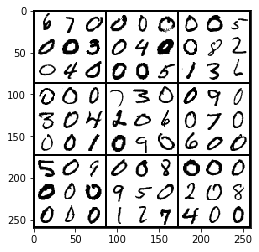

In [85]:
def show_sudoku(raw):
    return (torch.argmax(raw,2)+1)*(raw.sum(2).long())

def show_mnist_sudoku(raw):
    A = raw.numpy()
    digits = np.concatenate(np.concatenate(A,axis=1), axis=1).astype(np.uint8)
    linewidth = 2
    board = np.zeros((digits.shape[0]+linewidth*4, digits.shape[1]+linewidth*4), dtype=np.uint8)
    gridwidth = digits.shape[0]//3

    board[:] = 255
    for i in range(3):
        for j in range(3):
            xoff = linewidth+(linewidth+gridwidth)*i
            yoff = linewidth+(linewidth+gridwidth)*j
            xst = gridwidth*i
            yst = gridwidth*j
            board[xoff:xoff+gridwidth, yoff:yoff+gridwidth] = digits[xst:xst+gridwidth, yst:yst+gridwidth]

    #img = Image.fromarray(255-board)
    plt.imshow(255-board, cmap='gray')

display(Markdown('## Sudoku'))
print(show_sudoku(X_in[0]))
print()
display(Markdown('## One-hot encoded Boolean Sudoku'))
print(X[0])
    
display(Markdown('## MNIST Sudoku'))
show_mnist_sudoku(Ximg_in[0])

## Reviewing at the train/test set

In [23]:
# % of filled cells in the first example
a = show_sudoku(X_in[0])
'{:.2f}'.format(int((a != 0).sum()) / (9*9) * 100) + ' %'

'41.98 %'

In [24]:
all_per = []
for i in range(X_in.shape[0]):
    all_per.append(int((show_sudoku(X_in[i]) != 0).sum()) / 81)

In [25]:
import pandas as pd
all_per = pd.Series(all_per)

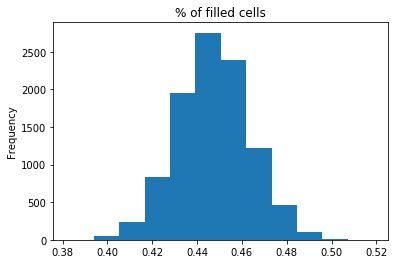

In [26]:
# % of filled cells over all samples
ax = all_per.plot.hist(bins=12, title='% of filled cells')

In [27]:
all_cnt = []
for i in range(X_in.shape[0]):
    all_cnt.append(int((show_sudoku(X_in[i]) != 0).sum()))
all_cnt = pd.Series(all_cnt)
all_cnt.value_counts()

36    2752
37    2383
35    1949
38    1222
34     838
39     458
33     232
40     107
32      46
41       8
31       3
42       2
dtype: int64

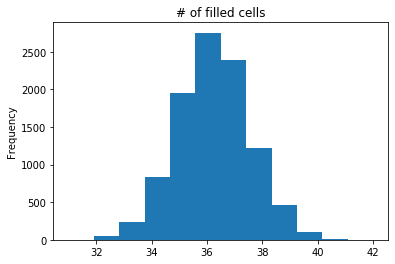

In [29]:
ax = all_cnt.plot.hist(bins=12, title='# of filled cells')

### Compare train/test set

In [31]:
# !pip install kaggle

In [35]:
!kaggle datasets download bryanpark/sudoku  --unzip

 98%|█████████████████████████████████████▍| 67.0M/68.1M [00:05<00:00, 12.5MB/s]
100%|██████████████████████████████████████| 68.1M/68.1M [00:05<00:00, 12.8MB/s]


In [37]:
kaggle_sudoku = pd.read_csv('./sudoku.csv')
kaggle_sudoku.shape

(1000000, 2)

In [39]:
kaggle_sudoku.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


In [43]:
%%time
quizzes = kaggle_sudoku.quizzes.apply(lambda x: np.array(list(x)).astype(int))
quizzes.head()

CPU times: user 26.3 s, sys: 187 ms, total: 26.5 s
Wall time: 26.5 s


0    [0, 0, 4, 3, 0, 0, 2, 0, 9, 0, 0, 5, 0, 0, 9, ...
1    [0, 4, 0, 1, 0, 0, 0, 5, 0, 1, 0, 7, 0, 0, 3, ...
2    [6, 0, 0, 1, 2, 0, 3, 8, 4, 0, 0, 8, 4, 5, 9, ...
3    [4, 9, 7, 2, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, ...
4    [0, 0, 5, 9, 1, 0, 3, 0, 8, 0, 0, 9, 4, 0, 3, ...
Name: quizzes, dtype: object

In [46]:
%%time
kaggle_cnt = quizzes.apply(lambda x: np.count_nonzero(x))

CPU times: user 728 ms, sys: 3.99 ms, total: 732 ms
Wall time: 731 ms


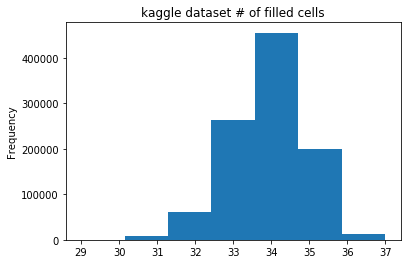

In [52]:
ax = kaggle_cnt.plot.hist(bins=7, title='kaggle dataset # of filled cells')

# The 9x9 Sudoku Experiment

The results for our 9x9 Sudoku experiment are below. In this experiment, we:
* **Input** a logical (bit) representation of the initial (unsolved) Sudoku board along with a mask representing which bits must be learned (i.e. all bits in empty Sudoku cells). This input is vectorized, which means that our SATNet model cannot exploit the locality structure of the input Sudoku grid when learning to solve puzzles.
* **Output** a bit representation of the Sudoku board with guesses for the unknown bits.

In [54]:
%%capture
sudoku_model = SudokuSolver(args.boardSz, args.aux, args.m)
if args.cuda: sudoku_model = sudoku_model.cuda()
    
optimizer = optim.Adam(sudoku_model.parameters(), lr=args.lr)

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
train_logger = FigLogger(fig, axes[0], 'Traininig')
test_logger = FigLogger(fig, axes[1], 'Testing')

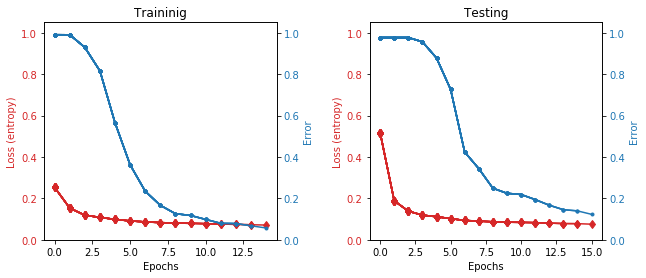

CPU times: user 19min 13s, sys: 5min 25s, total: 24min 38s
Wall time: 24min 38s


In [55]:
%%time
test(args.boardSz, 0, sudoku_model, optimizer, test_logger, sudoku_test, args.batchSz)
for epoch in range(1, args.nEpoch+1):
    train(args.boardSz, epoch, sudoku_model, optimizer, train_logger, sudoku_train, args.batchSz)
    test(args.boardSz, epoch, sudoku_model, optimizer, test_logger, sudoku_test, args.batchSz)
    clear_output()
    display(fig)

In [56]:
args

Args(lr=0.002, cuda=True, batchSz=128, mnistBatchSz=50, boardSz=3, m=600, aux=300, nEpoch=15)

In [87]:
# predict the first puzzle in the dataset
puzzle1 = sudoku_model(X[0:1], is_input[0:1])[0].cpu().detach().numpy()

In [91]:
puzzle1 = np.reshape(puzzle1,[9,9,9])#.argmax(axis=0)+1

In [92]:
# print solution
for i in range(9):
    print(puzzle1[i].argmax(axis=1)+1)

[6 7 8 3 1 2 9 4 5]
[1 5 3 6 4 9 7 8 2]
[9 4 2 8 7 5 1 3 6]
[2 6 5 7 3 1 8 9 4]
[3 9 4 2 8 6 5 7 1]
[7 8 1 5 9 4 6 2 3]
[5 2 9 4 6 8 3 1 7]
[4 1 7 9 5 3 2 6 8]
[8 3 6 1 2 7 4 5 9]


In [93]:
# print answer
for i in range(9):
    print(Y_in[0][i].argmax(axis=1)+1)

tensor([6, 7, 8, 3, 1, 2, 9, 4, 5])
tensor([1, 5, 3, 6, 4, 9, 7, 8, 2])
tensor([9, 4, 2, 8, 7, 5, 1, 3, 6])
tensor([2, 6, 5, 7, 3, 1, 8, 9, 4])
tensor([3, 9, 4, 2, 8, 6, 5, 7, 1])
tensor([7, 8, 1, 5, 9, 4, 6, 2, 3])
tensor([5, 2, 9, 4, 6, 8, 3, 1, 7])
tensor([4, 1, 7, 9, 5, 3, 2, 6, 8])
tensor([8, 3, 6, 1, 2, 7, 4, 5, 9])


In [94]:
# try another puzzle
a = np.array(list('004300209005009001070060043006002087190007400050083000600000105003508690042910300')).astype(int)
b = np.reshape(a, [9,9])
b

array([[0, 0, 4, 3, 0, 0, 2, 0, 9],
       [0, 0, 5, 0, 0, 9, 0, 0, 1],
       [0, 7, 0, 0, 6, 0, 0, 4, 3],
       [0, 0, 6, 0, 0, 2, 0, 8, 7],
       [1, 9, 0, 0, 0, 7, 4, 0, 0],
       [0, 5, 0, 0, 8, 3, 0, 0, 0],
       [6, 0, 0, 0, 0, 0, 1, 0, 5],
       [0, 0, 3, 5, 0, 8, 6, 9, 0],
       [0, 4, 2, 9, 1, 0, 3, 0, 0]])

In [95]:
(b != 0).sum()

35

In [119]:
t = []
for i in range(9):
    t.append(np.eye(10)[b[i]][:,1:])

In [158]:
ts = torch.tensor([t], dtype=torch.float32)

In [159]:
mask = ts.sum(dim=3, keepdim=True).expand_as(ts).int().sign()

In [163]:
#flatten
ts = ts.view(ts.size(0), -1).cuda()
mask = mask.view(mask.size(0), -1).cuda()

In [164]:
ts.shape, mask.shape

(torch.Size([1, 729]), torch.Size([1, 729]))

In [167]:
puzzle2 = sudoku_model(ts, mask).cpu().detach().numpy()

In [168]:
puzzle2 = np.reshape(puzzle2,[9,9,9])
# print solution
for i in range(9):
    print(puzzle2[i].argmax(axis=1)+1)

[8 6 4 3 7 1 2 5 9]
[3 2 5 8 4 9 7 6 1]
[9 7 1 2 6 5 8 4 3]
[4 3 6 1 9 2 5 8 7]
[1 9 8 6 5 7 4 3 2]
[2 5 7 4 8 3 9 1 6]
[6 8 9 7 3 4 1 2 5]
[7 1 3 5 2 8 6 9 4]
[5 4 2 9 1 6 3 7 8]


In [170]:
# hadest sudoku: http://forum.enjoysudoku.com/an-elementary-solution-of-platinium-blonde-t32949.html
platinum_blonde = '000000012000000003002300400001800005060070800000009000008500000900040500470006000'
pb = np.reshape(a, [9,9])
pb

array([[0, 0, 4, 3, 0, 0, 2, 0, 9],
       [0, 0, 5, 0, 0, 9, 0, 0, 1],
       [0, 7, 0, 0, 6, 0, 0, 4, 3],
       [0, 0, 6, 0, 0, 2, 0, 8, 7],
       [1, 9, 0, 0, 0, 7, 4, 0, 0],
       [0, 5, 0, 0, 8, 3, 0, 0, 0],
       [6, 0, 0, 0, 0, 0, 1, 0, 5],
       [0, 0, 3, 5, 0, 8, 6, 9, 0],
       [0, 4, 2, 9, 1, 0, 3, 0, 0]])

In [171]:
(pb != 0).sum()

35

In [185]:
def solve_puzzle(puzzle):
    t = []
    for i in range(9):
        t.append(np.eye(10)[puzzle[i]][:,1:])
    ts = torch.tensor([t], dtype=torch.float32)
    mask = ts.sum(dim=3, keepdim=True).expand_as(ts).int().sign()
    #flatten
    ts = ts.view(ts.size(0), -1).cuda()
    mask = mask.view(mask.size(0), -1).cuda()
    answer = sudoku_model(ts, mask).cpu().detach().numpy()
    answer = np.reshape(puzzle2,[9,9,9])
    # print solution
    ans = []
    for i in range(9):
        ans.append(answer[i].argmax(axis=1)+1)
    return ans

In [186]:
ans = solve_puzzle(pb)

In [187]:
ans

[array([8, 6, 4, 3, 7, 1, 2, 5, 9]),
 array([3, 2, 5, 8, 4, 9, 7, 6, 1]),
 array([9, 7, 1, 2, 6, 5, 8, 4, 3]),
 array([4, 3, 6, 1, 9, 2, 5, 8, 7]),
 array([1, 9, 8, 6, 5, 7, 4, 3, 2]),
 array([2, 5, 7, 4, 8, 3, 9, 1, 6]),
 array([6, 8, 9, 7, 3, 4, 1, 2, 5]),
 array([7, 1, 3, 5, 2, 8, 6, 9, 4]),
 array([5, 4, 2, 9, 1, 6, 3, 7, 8])]

In [192]:
import itertools

def sudoku_ok(line):
    return (len(line) == 9 and sum(line) == sum(set(line)))

def check_sudoku(grid):
    bad_rows = [row for row in grid if not sudoku_ok(row)]
    grid = list(zip(*grid))
    bad_cols = [col for col in grid if not sudoku_ok(col)]
    squares = []
    for i in range(0,9,3):
        for j in range(0,9,3):
          square = list(itertools.chain(row[j:j+3] for row in grid[i:i+3]))
          squares.append(square)
    bad_squares = [square for square in squares if not sudoku_ok(square)]
    return not (bad_rows or bad_cols or bad_squares)

In [193]:
check_sudoku(ans)

False

# The Permuted 9x9 Sudoku Experiment

The results for our permuted 9x9 Sudoku experiment are below. In this experiment, we:
* **Input** the same inputs as in the original 9x9 Sudoku experiment, but with a fixed permutation applied.
* **Output** a bit representation of the permuted Sudoku board with guesses for the unknown bits.

In [10]:
%%capture
perm_model = SudokuSolver(args.boardSz, args.aux, args.m)
if args.cuda: perm_model = perm_model.cuda()
    
optimizer = optim.Adam(perm_model.parameters(), lr=args.lr)

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
train_logger = FigLogger(fig, axes[0], 'Traininig')
test_logger = FigLogger(fig, axes[1], 'Testing')

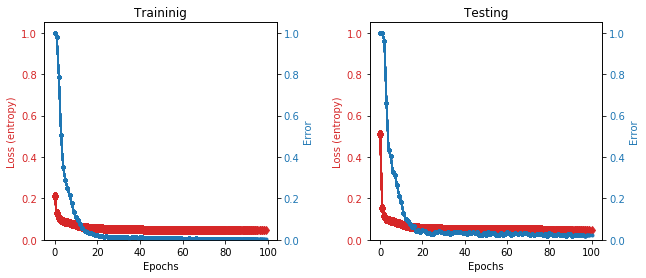

In [11]:
unperm = find_unperm(perm)
test(args.boardSz, 0, perm_model, optimizer, test_logger, perm_test, args.batchSz, unperm)
for epoch in range(1, args.nEpoch+1):
    train(args.boardSz, epoch, perm_model, optimizer, train_logger, perm_train, args.batchSz, unperm)
    test(args.boardSz, epoch, perm_model, optimizer, test_logger, perm_test, args.batchSz, unperm)
    clear_output()
    display(fig)

# The End-to-End MNIST Sudoku ("Visual Sudoku") Experiment

The results for our permuted 9x9 Sudoku experiment are below. In this experiment, we:
* **Input** an image representation of the initial (unsolved) Sudoku board.
* **Output** a bit representation of the Sudoku board with guesses for the unknown bits.

In [12]:
%%capture
mnist_sudoku = MNISTSudokuSolver(args.boardSz, args.aux, args.m)
if args.cuda: mnist_sudoku = mnist_sudoku.cuda()
    
optimizer = optim.Adam([
            {'params': mnist_sudoku.sudoku_solver.parameters(), 'lr': args.lr},
            {'params': mnist_sudoku.digit_convnet.parameters(), 'lr': 1e-5},
            ])

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
train_logger = FigLogger(fig, axes[0], 'Traininig')
test_logger = FigLogger(fig, axes[1], 'Testing')

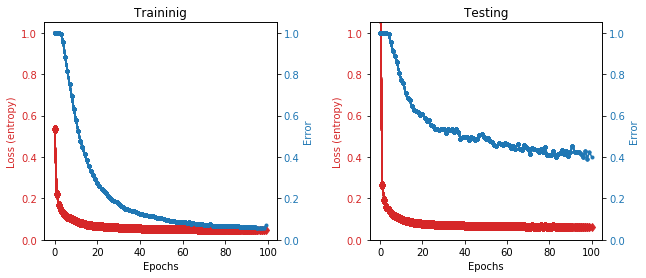

In [13]:
test(args.boardSz, 0, mnist_sudoku, optimizer, test_logger, mnist_test, args.mnistBatchSz)
for epoch in range(1, args.nEpoch+1):
    train(args.boardSz, epoch, mnist_sudoku, optimizer, train_logger, mnist_train, args.mnistBatchSz)
    test(args.boardSz, epoch, mnist_sudoku, optimizer, test_logger, mnist_test, args.mnistBatchSz)
    clear_output()
    display(fig)